In [1]:
# 1) установить gdown (разово)
!pip install -q -U gdown

In [2]:
# 2) скачать всю папку в /content/drive_folder
FOLDER_URL="https://drive.google.com/drive/folders/1B8oObPiWMzbnvihodze71Vjv-N4nbpxU"
!gdown --folder $FOLDER_URL -O /content/drive_folder
!ls -la /content/drive_folder

Retrieving folder contents
Processing file 1T6QuFUReIV9w960v63msOIlqZiW0Gn9- fpr.png
Processing file 1ODCY8w6dJFmxVap6Ty2oYfCbXZsxkqPH rocauc.png
Processing file 10XYwnIpwEf6JTS8_9QfrN9iLzvsTT72- SHIFT_ML_2025_COMPETITION.zip
Processing file 1jejmAa5GW_elzFg2JvXFwsWJc2hDQnxH tpr.png
Processing file 1Ej7oMNl5Gc5S0dKhHmeF_IY-zsFUoTMq ответ.png
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6QuFUReIV9w960v63msOIlqZiW0Gn9-
To: /content/drive_folder/fpr.png
100% 4.11k/4.11k [00:00<00:00, 7.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ODCY8w6dJFmxVap6Ty2oYfCbXZsxkqPH
To: /content/drive_folder/rocauc.png
100% 45.0k/45.0k [00:00<00:00, 63.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10XYwnIpwEf6JTS8_9QfrN9iLzvsTT72-
From (redirected): https://drive.google.com/uc?id=10XYwnIpwEf6JTS8_9QfrN9iLzvsTT72-&confirm=t&uuid=a3e8175f-96fa-4d52-9cfd-441e7c

In [3]:
!unzip -o /content/drive_folder/SHIFT_ML_2025_COMPETITION.zip -d /content/drive_folder/SHIFT_ML_2025_COMPETITION


Archive:  /content/drive_folder/SHIFT_ML_2025_COMPETITION.zip
  inflating: /content/drive_folder/SHIFT_ML_2025_COMPETITION/baseline.ipynb  
  inflating: /content/drive_folder/SHIFT_ML_2025_COMPETITION/__MACOSX/._baseline.ipynb  
  inflating: /content/drive_folder/SHIFT_ML_2025_COMPETITION/shift_ml_2025_test.csv  
  inflating: /content/drive_folder/SHIFT_ML_2025_COMPETITION/__MACOSX/._shift_ml_2025_test.csv  
  inflating: /content/drive_folder/SHIFT_ML_2025_COMPETITION/shift_ml_2025_train.csv  
  inflating: /content/drive_folder/SHIFT_ML_2025_COMPETITION/__MACOSX/._shift_ml_2025_train.csv  


# 1 ТЕСТ


In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import joblib

RND = 42
np.random.seed(RND)
random.seed(RND)
os.environ['PYTHONHASHSEED'] = str(RND)

In [2]:
train = pd.read_csv("/content/drive_folder/SHIFT_ML_2025_COMPETITION/shift_ml_2025_train.csv")
test  = pd.read_csv("/content/drive_folder/SHIFT_ML_2025_COMPETITION/shift_ml_2025_test.csv")

# Предположим, что таргет называется 'итоговый_статус_займа', id колонка — 'id'
TARGET = 'итоговый_статус_займа'
ID_COL = 'id'  # поправь если по-другому

print("train:", train.shape)
print("test:", test.shape)
print(train[TARGET].value_counts(normalize=True))


/tmp/ipython-input-866164909.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive_folder/SHIFT_ML_2025_COMPETITION/shift_ml_2025_train.csv")


train: (1210779, 109)
test: (134531, 108)
итоговый_статус_займа
0    0.800381
1    0.199619
Name: proportion, dtype: float64


In [3]:
def quick_eda(df, name=""):
    print(f"=== {name} shape:", df.shape)
    print("NA per col (top 10):")
    print(df.isna().mean().sort_values(ascending=False).head(10))
    print("dtypes:")
    print(df.dtypes.value_counts())

quick_eda(train, "train")
quick_eda(test, "test")

=== train shape: (1210779, 109)
NA per col (top 10):
дата_следующей_выплаты                                              1.000000
кредитный_баланс_по_возоб_счетам                                    0.986118
совокупный_статус_подтверждения_доходов_заемщиков                   0.980963
совокупный_пдн_заемщиков                                            0.980813
совокупный_доход_заемщиков                                          0.980812
кол-во_месяцев_с_последнего_займа                                   0.830141
кол-во_мес_с_последней_задолженности_по_карте                       0.762746
кол-во_месяцев_с_последнего_нарушения                               0.736815
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету       0.665356
соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам    0.654447
dtype: float64
dtypes:
float64    84
object     19
int64       6
Name: count, dtype: int64
=== test shape: (134531, 108)
NA per col (top 10):
дата_следующей_выплаты             

In [9]:
# ===: простая предобработка :===
#  разделим на числовые/категориальные
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

# удаляем ID и таргет из фичей
if ID_COL in num_cols: num_cols.remove(ID_COL)
if TARGET in num_cols: num_cols.remove(TARGET)
if ID_COL in cat_cols: cat_cols.remove(ID_COL)
if TARGET in cat_cols: cat_cols.remove(TARGET)

print("num cols:", len(num_cols))
print("cat cols:", len(cat_cols))

# числовые -> median, категориальные -> 'MISSING'
for c in num_cols:
    med = train[c].median()
    train[c] = train[c].fillna(med)
    test[c] = test[c].fillna(med)

for c in cat_cols:
    train[c] = train[c].fillna("MISSING")
    test[c] = test[c].fillna("MISSING")

# частотное кодирование для категорий с высокой кардинальностью
for c in cat_cols:
    freq = train[c].value_counts(normalize=True)
    train[f"{c}_freq"] = train[c].map(freq)
    test[f"{c}_freq"]  = test[c].map(freq)

# конверт категориальные колонки в 'category' dtype для LightGBM
for c in cat_cols:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

# обнов списки признаков
feature_cols = [c for c in train.columns if c not in [ID_COL, TARGET]]
print("features after basic FE:", len(feature_cols))

num cols: 107
cat cols: 19
features after basic FE: 126


In [6]:
!pip install lightgbm==4.5.0

In [10]:
# ===: KFold + LightGBM training :===
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': RND,
    'n_jobs': -1,
    'verbosity': -1
}

oof = np.zeros(len(train))
preds = np.zeros(len(test))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
for fold, (tr_idx, val_idx) in enumerate(skf.split(train, train[TARGET])):
    X_tr = train.iloc[tr_idx][feature_cols]
    y_tr = train.iloc[tr_idx][TARGET]
    X_val = train.iloc[val_idx][feature_cols]
    y_val = train.iloc[val_idx][TARGET]

    dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=cat_cols)
    model = lgb.train(
        params, dtrain,
        num_boost_round=5000,
        valid_sets=[dtrain, dval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=100)
        ]
    )
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    preds += model.predict(test[feature_cols], num_iteration=model.best_iteration) / skf.n_splits

    # Сохраним модель
    joblib.dump(model, f"lgb_fold{fold}.pkl")

print("CV AUC:", roc_auc_score(train[TARGET], oof))

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.901514	valid_1's auc: 0.881271
[200]	training's auc: 0.917651	valid_1's auc: 0.881927
Early stopping, best iteration is:
[198]	training's auc: 0.917413	valid_1's auc: 0.88194
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.90173	valid_1's auc: 0.881546
[200]	training's auc: 0.917976	valid_1's auc: 0.882106
Early stopping, best iteration is:
[162]	training's auc: 0.912777	valid_1's auc: 0.882153
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.90145	valid_1's auc: 0.881967
[200]	training's auc: 0.91796	valid_1's auc: 0.882603
Early stopping, best iteration is:
[165]	training's auc: 0.913072	valid_1's auc: 0.882639
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.901646	valid_1's auc: 0.881
[200]	training's auc: 0.917953	valid_1's auc: 0.88167
[300]	training's auc: 0.92886	valid_1's auc: 0.881

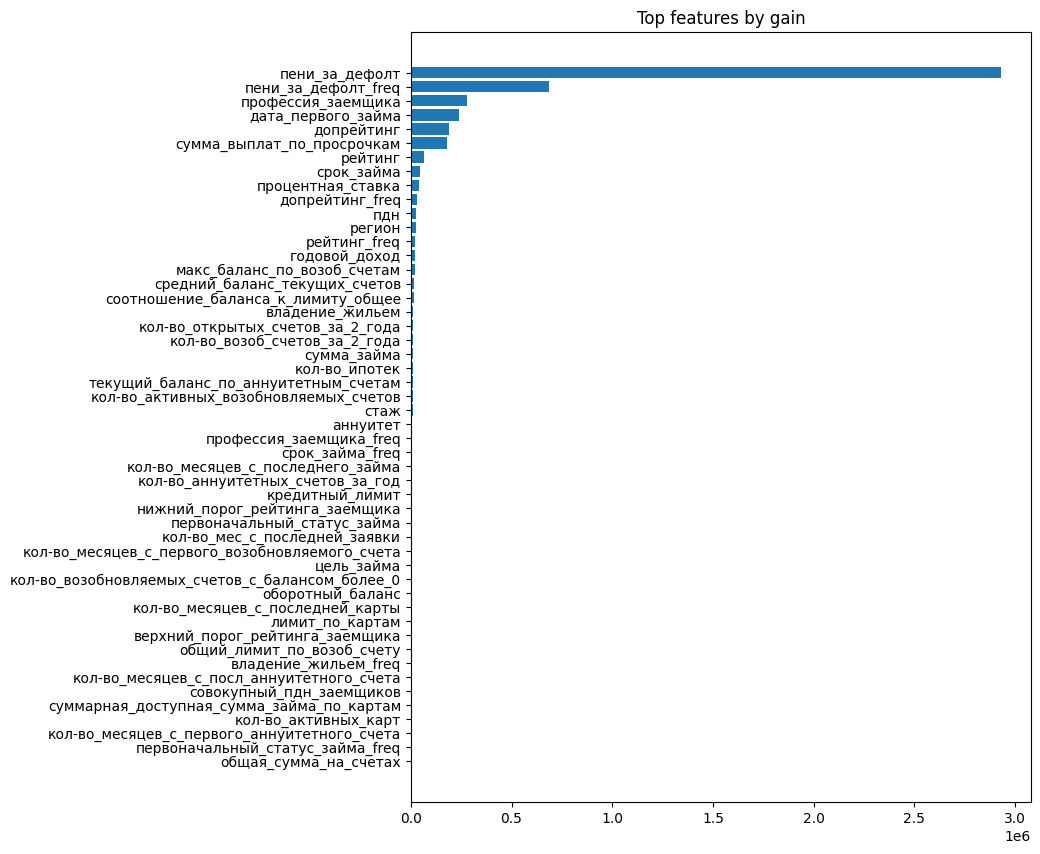

Saved submission.csv head:
         id     Proba
0  85540387  0.095165
1  28112500  0.052604
2  65731570  0.070106
3  65874747  0.544631
4  57893355  0.249901


In [11]:
# === Feature importance  ===
import matplotlib.pyplot as plt
fi = pd.DataFrame()
for fold in range(5):
    m = joblib.load(f"lgb_fold{fold}.pkl")
    tmp = pd.DataFrame({'feature':feature_cols, f'gain_fold{fold}': m.feature_importance(importance_type='gain')})
    if fi.empty: fi = tmp
    else: fi = fi.merge(tmp, on='feature', how='left')
fi['gain_mean'] = fi[[c for c in fi.columns if 'gain_fold' in c]].mean(axis=1)
fi = fi.sort_values('gain_mean', ascending=False).head(50)
plt.figure(figsize=(8,10))
plt.barh(fi['feature'], fi['gain_mean'])
plt.gca().invert_yaxis()
plt.title("Top features by gain")
plt.show()

# ===: формирование submission.csv :===
submission = pd.DataFrame({ID_COL: test[ID_COL], 'Proba': preds})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv head:")
print(submission.head())

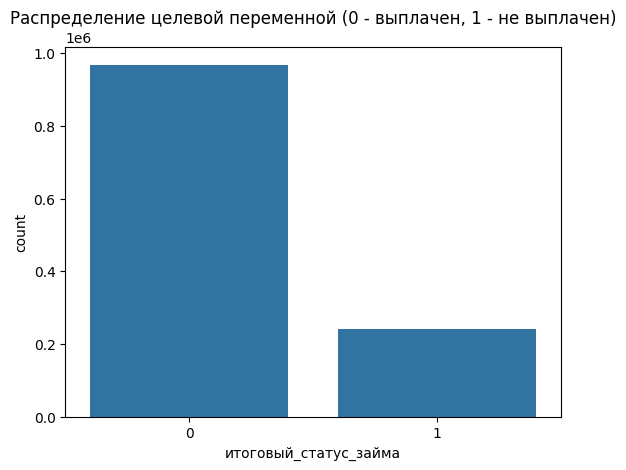

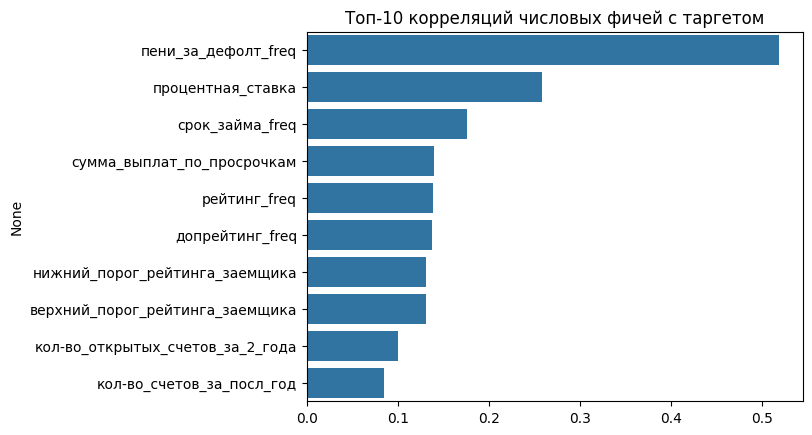

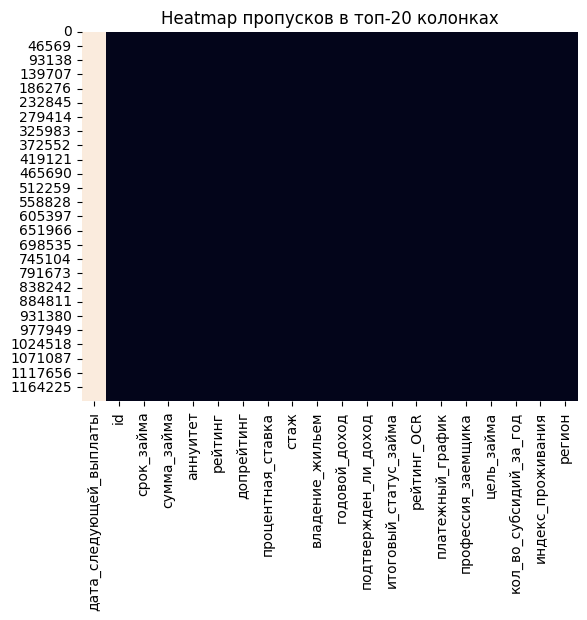

In [13]:
# === Расширенный EDA ===
import seaborn as sns
# Гипотеза 1: Дисбаланс классов влияет на метрики, поэтому проверим распределение таргета
sns.countplot(x=train[TARGET])
plt.title("Распределение целевой переменной (0 - выплачен, 1 - не выплачен)")
plt.show()

# Гипотеза 2: Корреляция числовых фичей с таргетом (топ-10)
corr = train[num_cols + [TARGET]].corr()[TARGET].abs().sort_values(ascending=False).head(11)[1:]  # Исключаем сам таргет
sns.barplot(x=corr.values, y=corr.index)
plt.title("Топ-10 корреляций числовых фичей с таргетом")
plt.show()

# Визуализация пропусков (heatmap для топ-20 колонок с NA)
top_na_cols = train.isna().mean().sort_values(ascending=False).head(20).index
sns.heatmap(train[top_na_cols].isna(), cbar=False)
plt.title("Heatmap пропусков в топ-20 колонках")
plt.show()

Confusion Matrix:
[[960027   9058]
 [115667 126027]]
TPR (Recall): 0.5214
FPR: 0.0093
Accuracy (ACC): 0.8970
Precision: 0.9329
F1-Score: 0.6690


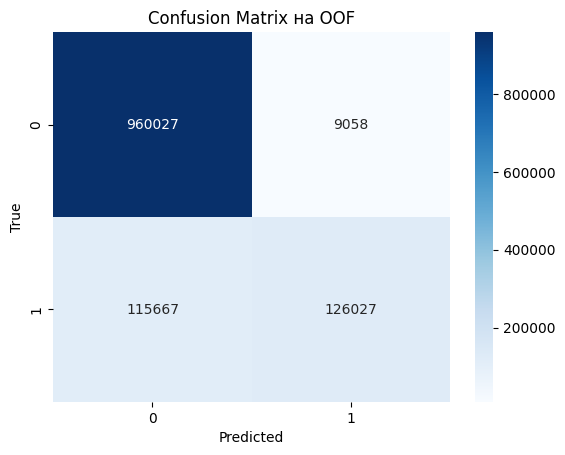

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# === Дополнительные метрики на OOF ===
# Бинаризуем OOF-предсказания по порогу 0.5 для confusion matrix
oof_pred_binary = (oof > 0.5).astype(int)
cm = confusion_matrix(train[TARGET], oof_pred_binary)
tn, fp, fn, tp = cm.ravel()

# Расчет метрик
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
acc = accuracy_score(train[TARGET], oof_pred_binary)
precision = precision_score(train[TARGET], oof_pred_binary)
recall = recall_score(train[TARGET], oof_pred_binary)  # Это TPR
f1 = f1_score(train[TARGET], oof_pred_binary)

print(f"Confusion Matrix:\n{cm}")
print(f"TPR (Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"Accuracy (ACC): {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

# Визуализация Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix на OOF')
plt.show()

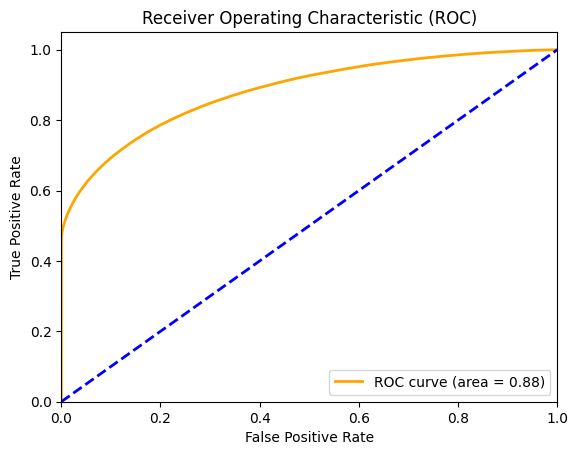

In [15]:
from sklearn.metrics import roc_curve, auc
# === Визуализация ROC-кривой ===
fpr, tpr, thresholds = roc_curve(train[TARGET], oof)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [8]:
requirements = """
pandas==2.2.2
numpy==1.26.4
lightgbm==4.5.0
scikit-learn==1.5.1
joblib==1.4.2
matplotlib==3.9.1
seaborn==0.13.2
"""
with open('requirements.txt', 'w') as f:
    f.write(requirements)
print("requirements.txt создан")

requirements.txt создан
